# Predicting Retail Electricity Prices Using Fossil Fuel Prices
## Supervised Machine Learning Approaches
### Monthly Data by State, Energy Type, and Sector from January 2008 to July 2020

## 1. Introduction

I will be predicting average retail electricity prices throughout the United States for nearly twelve (12) years by month and state based upon fossil fuel prices and generation volumes by energy type.  The power generation industry is a very long-term industry with most company revenue contracts and fixed asset investment horizons ranging from ten (10) to thirty (30) years long.  When making such large, long-term investments and commitments, power generators expose themselves to significant known and unknown business risks.  Today, generators are exposed more and more to fluctuating energy market prices with the continued establishment of idependent system operators (ISOs).  Being able to forecast energy prices accurately will assist with strategic positioning (i.e. if this nuclear plant shuts down, what will power prices do for 1 month, 3 months, or 6 months) and risk management by calibrating hedging and swap portfolios.

#### 1. Assuming trends in fossil fuel production and pricing markets, can we reasonably predict retail electricity prices by month and state?
Being able to predict changes in electricity prices relative to changes in fossil fuel markets improves strategic visibility for regional acquisitions and could improve risk management by quantifying incoming market impacts from upstream events and improving calibration of hedging portfolios.

#### 2. Can retail power prices be reasonably determined based only on the cost inputs of fossil fuels and not any renewable power or nuclear generation costs?
If the modeled predictions are reasonably accurate, we can observe market spark margin efficiencies and conclude renewable power companies need to guide their merchant power price strategy based on expected long-term fossil-fuel markets.

## 2. Data

The dataset has been downloaded from the Energy Information Administration (EIA) website at https://www.eia.gov/electricity/data/browser/, or https://www.eia.gov/opendata/qb.php?category=40.  The data is somewhat comprehensive including generation statistics, average fuel costs, fuel deliveries, fuel consumption, and fuel inventories.  For this project I used these feature variable to predict the average retail electricity prices in the United States on a monthly basis from 2001 to July 2020.  The electricity price data is broken down by region, state, and sector, and has been downloaded into a usable .csv file in the local folder. 
 
Within the electricity prices report, there are 7,701 observations and twenty-two (22) variables including location, sequential year, month number, sector, the target electricity price variable, the average cost of fossil fuels in electricity generation, net generation, fossil fuel stocks, and fuel consumption volumes by electricity generation.  There are toggles so that the project can be run with state-level data or region-level data by location, but not both as to avoid the effects of overlapping and cocorrelation from variables which may overlap.

 - __Energy Types:__ Coal, Natural Gas,	Petroleum Coke,	Petroleum Liquids, Renewable and Other Forms, and General Electricity (the electricity prices are not broken down by energy type, but only location and sector really).
 - __Sectors:__ Commercial, Industrial, Residential, Electric Utility, Independent Power Producers

In [1]:
# # Import Python libraries.
from custom_functions import (
    short_to_long_form_and_wrangle,
    correct_section_classification,
    correct_energy_units,
    show_category_breakdown,
    show_agg_stats_by_category,
    long_form_to_xdate,
    null_table_graph,
    back_forward_fill,
    drop_empty_multi_idx_cols,
    plot_discrete_features_by_col_idx,
    times_series_to_long_form,
    get_model_df,
    adjust_MMBtu_units,
    add_chrono_features,
    show_distributions,
    transform_check_distributions,
    discrete_feature_effects,
    split_training_test_data,
    show_correlations,
    generate_linear_regression,
    # ----------------
    pd,
    np,
    plt,
    sns,
    df_img_out,
    RandomForestRegressor,
    RandomizedSearchCV,
    GridSearchCV,
    SVR,
    GradientBoostingRegressor,
    RidgeCV,
    LassoCV,
    ElasticNetCV,
    cross_val_score,
    mean_absolute_error,
    mse,
    rmse
)
%matplotlib inline

# Import Raw Data and View Row/Column Schema

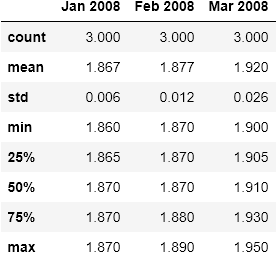

In [2]:
# Data obtained from EIA at https://www.eia.gov/electricity/data/browser/, 'View a pre-generated report'.
eia_raw_data_df = pd.read_csv('eia_data.csv').drop(columns=['index'])
df_img_out(eia_raw_data_df.head(3).iloc[:, :7].describe(), 'eia_raw_data_df')
target_var = 'Average_retail_price_of_electricity_cents_per_kilowatthour'

# Convert and Wrangle Data to Long-long Format

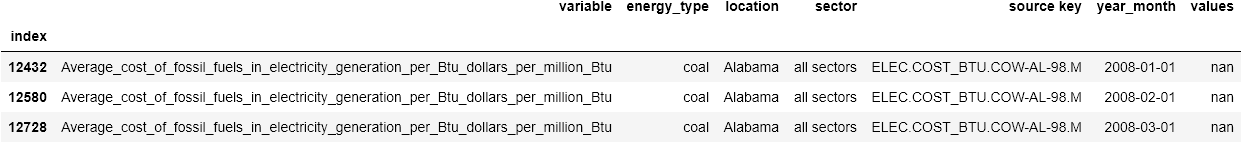

In [3]:
folder_df_nz_long = short_to_long_form_and_wrangle(eia_raw_data_df, loc_method='state')
df_img_out(folder_df_nz_long.head(3).iloc[:, :7], 'folder_df_nz_long')

# Correct 'sector' Bad Data in Receipts of Fossil Fuels Variables

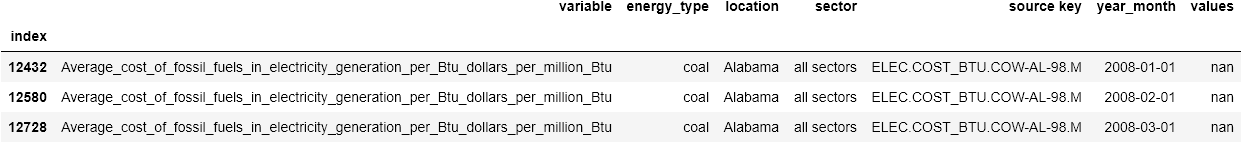

In [4]:
folder_df_nz_long_sct = correct_section_classification(folder_df_nz_long)
df_img_out(folder_df_nz_long.head(3).iloc[:, :7], 'folder_df_nz_long_sct')

In [5]:
folder_df_nz_long_sct_conv = correct_energy_units(folder_df_nz_long_sct)

# Data Structure: Categroical Variable Values (Location, Energy Type, and Industry Sector)

We can see that petroleum coke 'energy_type' and residential 'sector' have very limited data points, however, petroleum coke was not recorded as much throughout various states nor was it recorded over a similarly long period of time.  Petroleum coke comprises a significant portion of the energy markets and is a key source of cost-effective energy value for electricity generation because it is a bi-product (not a primary output) of the petroleum refining process.

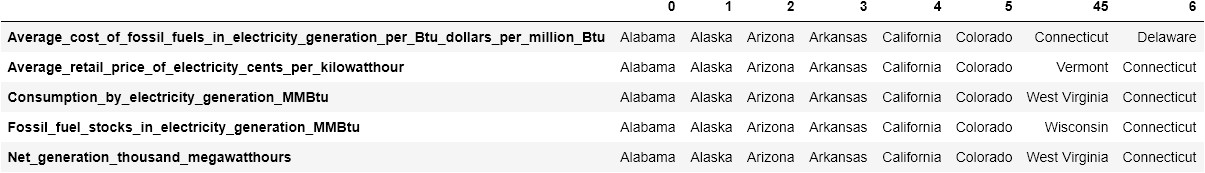

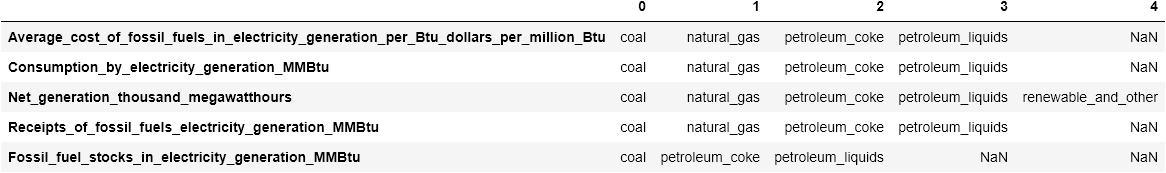

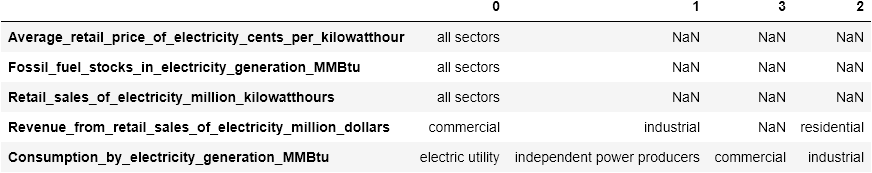

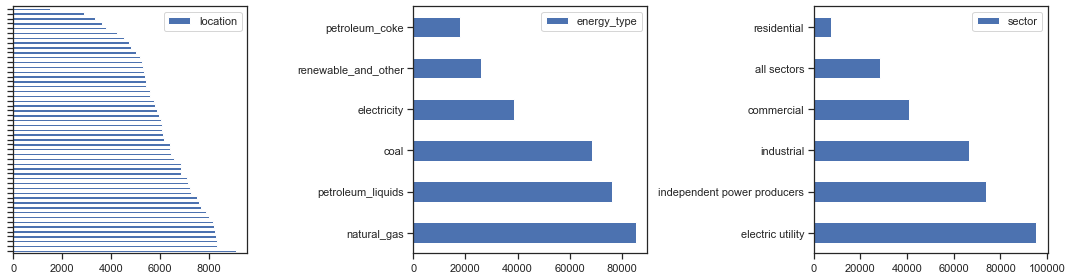

In [6]:
show_category_breakdown(folder_df_nz_long_sct_conv, 'variable', ['location', 'energy_type', 'sector'])

# Data Structure: Categorical Group Statistics and Value Ranges

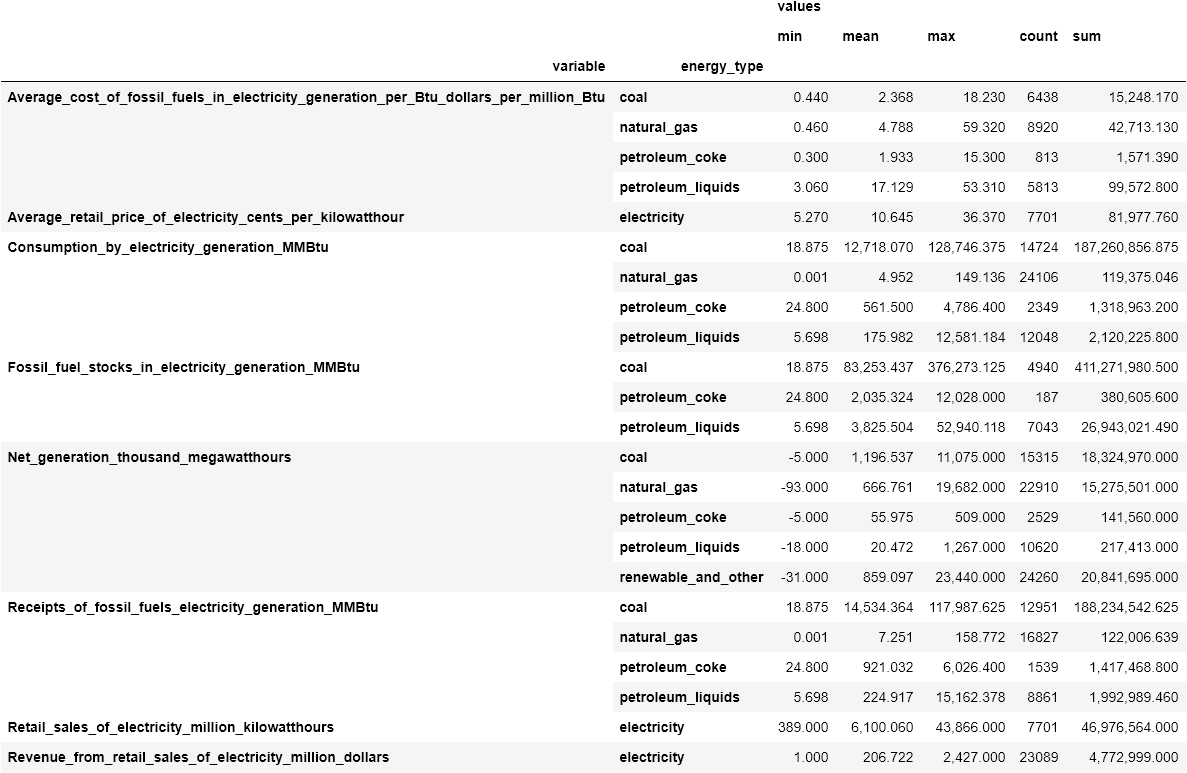

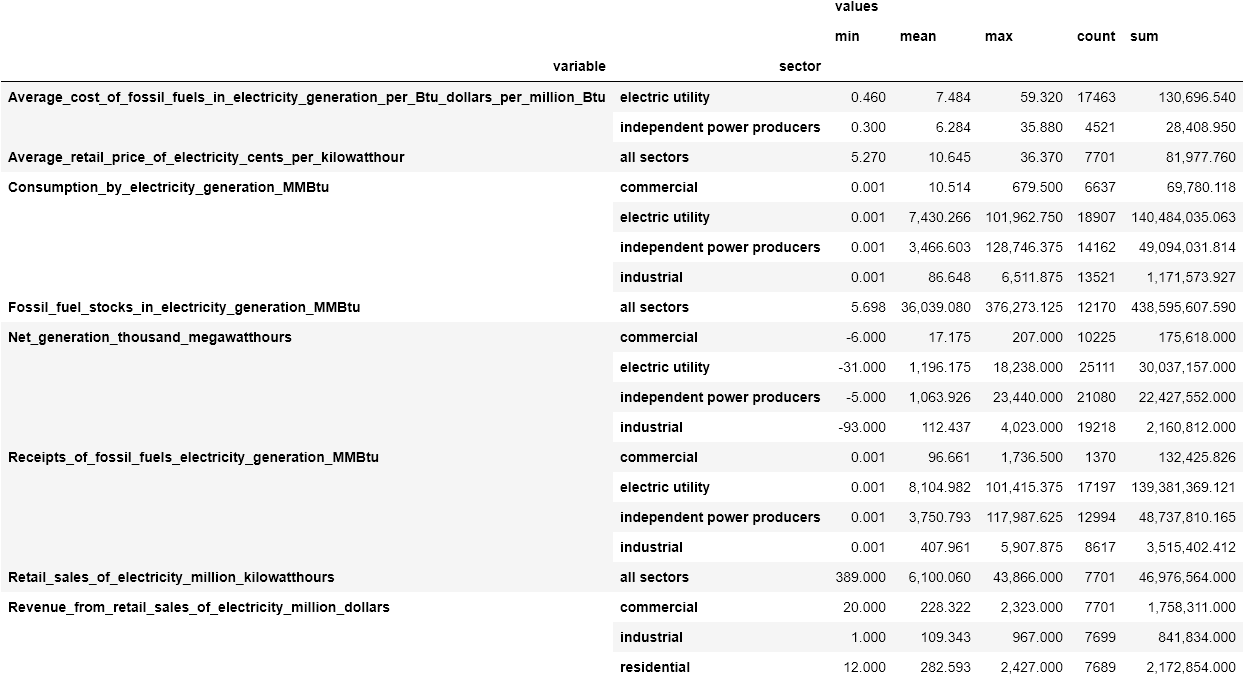

In [7]:
show_agg_stats_by_category(folder_df_nz_long_sct_conv, ['energy_type', 'sector'],
                           ['min', 'mean', 'max', 'count', 'sum'])

# Wrangle Data to Chronological Time-Series Format with 'year_month' as the X-axis.

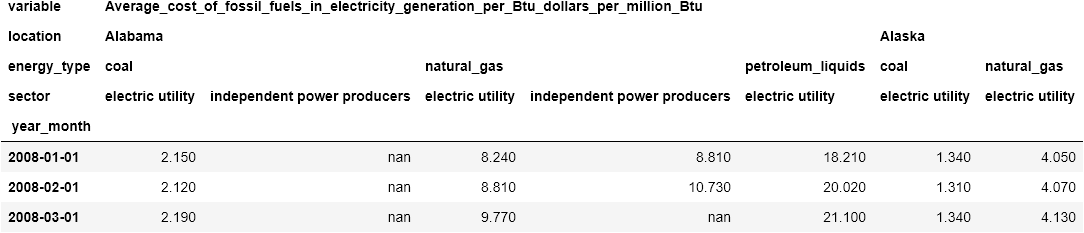

In [8]:
folder_df_nz_xdate = long_form_to_xdate(folder_df_nz_long_sct_conv)
df_img_out(folder_df_nz_xdate.head(3).iloc[:, :7], 'folder_df_nz_xdate')

# Data Cleaning: Chronologically Forward-fill and Back-fill variable data after breaking it down by variable, location, and energy type.

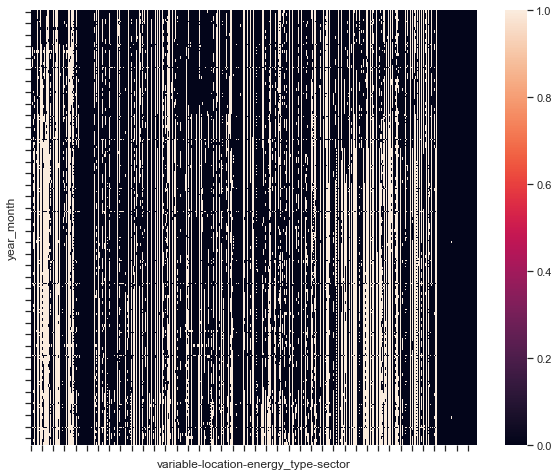

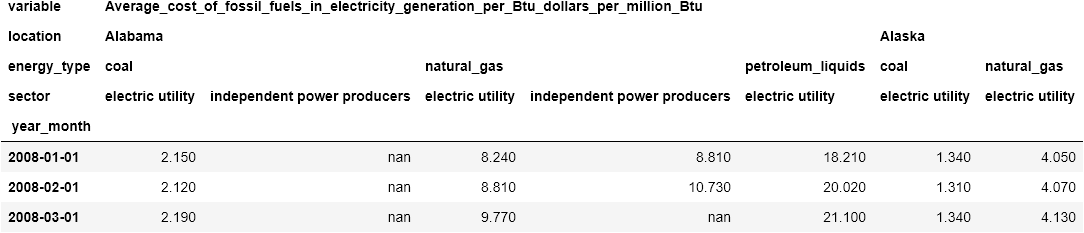

In [9]:
null_table_graph(folder_df_nz_xdate.replace([0, np.inf, -np.inf], np.nan))
df_img_out(folder_df_nz_xdate.head(3).iloc[:, :7], 'folder_df_nz_xdate2')


Showing the difference in .describe() statistics after applying the fill assumptions.



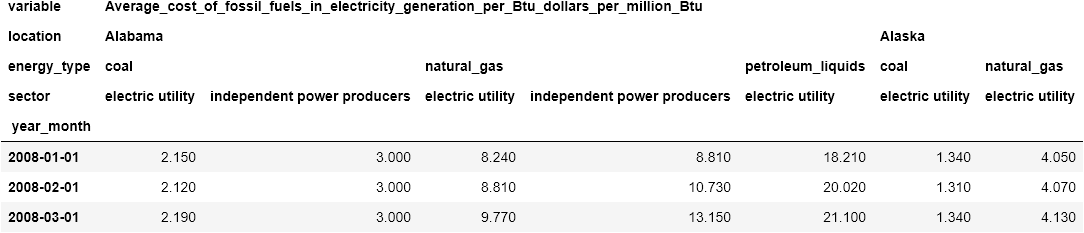

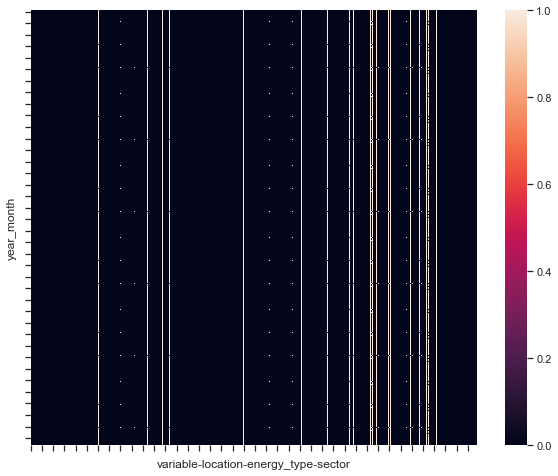

In [10]:
folder_df_nz_xdate_fill = back_forward_fill(folder_df_nz_xdate)
print("\nShowing the difference in .describe() statistics after applying the fill assumptions.\n")
df_img_out(folder_df_nz_xdate_fill.head(3).iloc[:, :7], 'folder_df_nz_xdate_fill')
null_table_graph(folder_df_nz_xdate_fill)

Change in count of columns after dropping: -99 (2,172 remaining columns)


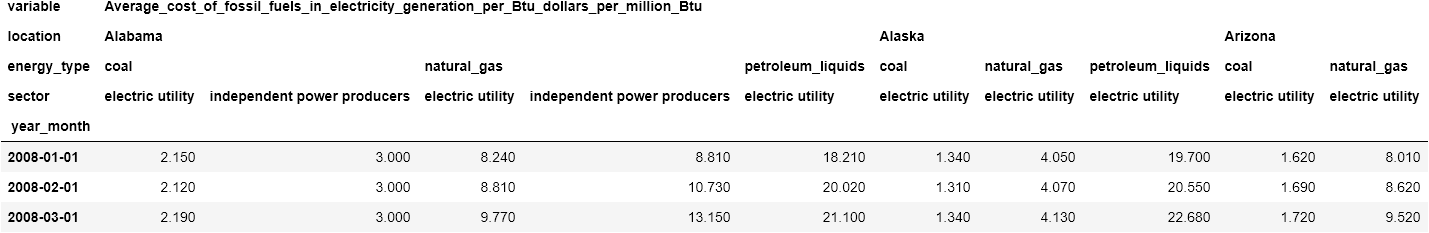

In [11]:
folder_df_nz_xdate_fill_drop = drop_empty_multi_idx_cols(folder_df_nz_xdate_fill)
col_count_chg = folder_df_nz_xdate_fill_drop.columns.size - folder_df_nz_xdate_fill.columns.size
print("Change in count of columns after dropping: {:,.0f} ({:,.0f} remaining columns)".format(
    col_count_chg, folder_df_nz_xdate_fill_drop.columns.size))
df_img_out(folder_df_nz_xdate_fill_drop.head(3).iloc[:, :10], 'folder_df_nz_xdate_fill_drop')

# Chronological Trends in Raw Variable Values: Fossil Fuel Costs, Consumption, Inventory Stocks

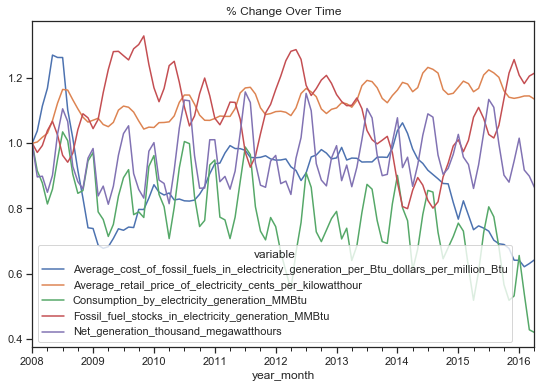

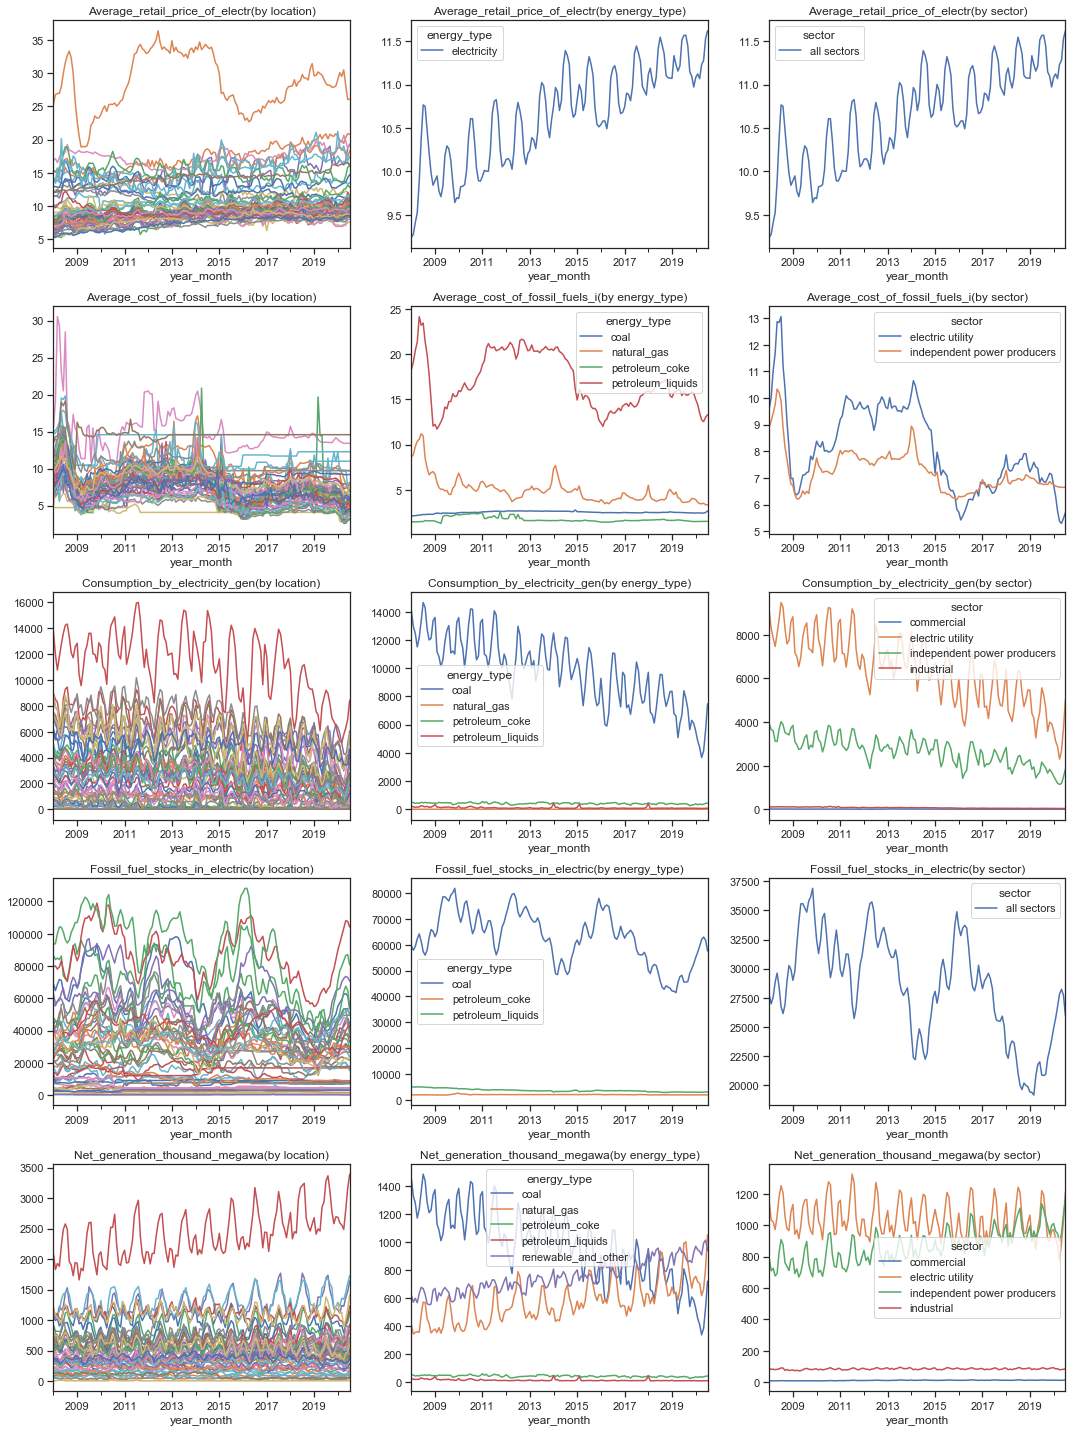

In [12]:
plot_discrete_features_by_col_idx(folder_df_nz_xdate_fill_drop, target_var.split('__')[0])

 - We can see that the average retail price of electricity tends to move seasonally throughout the year by the monthly data.  If we had daily data, we would see the variation between on-peak and off-peak hours, but that is beyond the scope of this project.

 - The gradual increase in electricity prices generally tend to appear inflationary and track coal prices, as coal is such a significant portion of the overall power grid.  Natural gas, petroleum coke, and petroleum liquids fuel prices have trended downward over the past five years as the natural gas glut from fracking continues to maintain negative pricing pressure across the markets.

 - It is interesting that the average cost of fuel between utilities and independent power generators generally shows that private companies are more efficient at maintaining low costs in their operational processes and procurement by a noticeable margin when compared to quasi-governmental utility generators which are heavily regulated.

 - Looking at consumption of fuels for electricity, utilities are a much larger portion of the market than independent power producers but still cannot garner pricing economies of scale in fuel costs comparatively.
 
 - Independent power generators have been steadily increasing their portion of total generation over the past decade and are now at a similar production level than utility companies.
  
 - Coal generation has been decreasing to about half of its level a decade ago, while being replaced with natural gas and renewable energy sources.

 - Receipts of all types of fossil fuels have been declining consistently, except for natural gas.
 
 - Fossil fuel stocks of all types reaches a very low level in 2019.

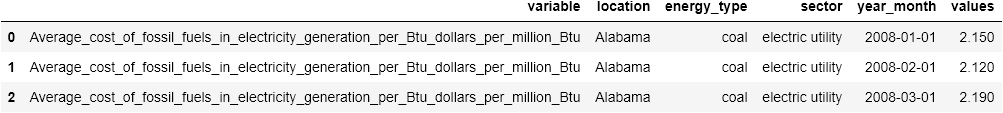

In [13]:
df_fill_long = times_series_to_long_form(folder_df_nz_xdate_fill_drop)
df_img_out(df_fill_long.head(3).iloc[:, :10], 'df_fill_long')

# Data Wrangling: Make Data Ready for Machine Learning Models

In order to homogenize the data columns more, I converted each of the fossil-fuel-related variables from either tons, metric cubic feet, or gallons of fossil fuels into British Thermal Units (BTUs) so the figures the machine learning model is comparing are of the same units across various energy types of generation.  We can also see a more accurate, relevant, and sometimes very different pricing perspective when comparing fossil fuel costs by energy content rather than weight or volume.

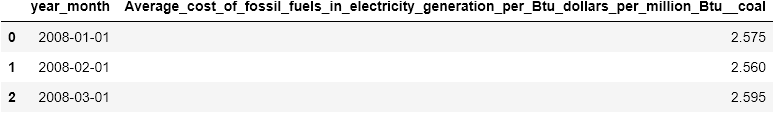

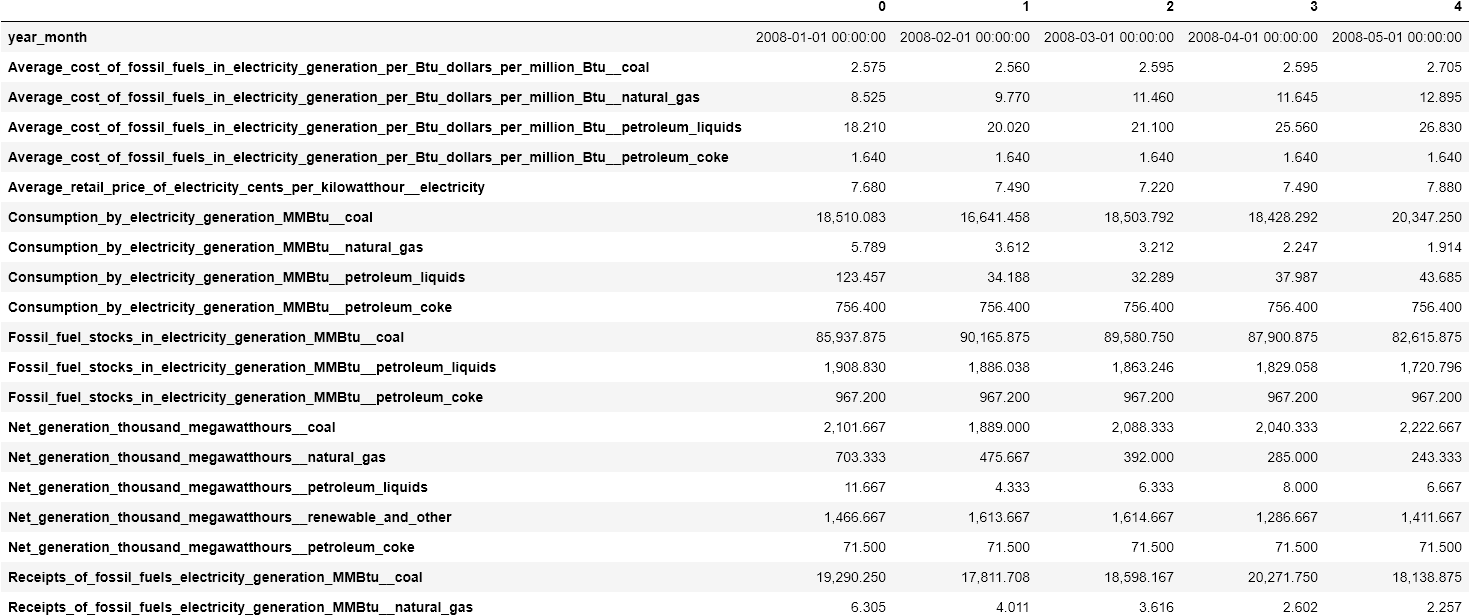

In [30]:
# Get DataFrame format ready for data modeling.
model_df = get_model_df(df_fill_long)
model_df = model_df.reset_index().drop(columns='location')
df_img_out(model_df.iloc[:3, :2], 'model_df')
df_img_out(model_df.iloc[:5, :20].transpose(), 'model_df')

# Adjust MMBtu Variable Units to Decrease Relative Magnitude Versus Other Variable Values

In [16]:
model_df2 = adjust_MMBtu_units(model_df)

# Create Chronological Features: Capturing Seasonality by Month and Sequential Time Increments of Years and Months

In [17]:
model_df3 = add_chrono_features(model_df2)

# Review Distributions of Variables and Perform Log Transformations

 - The average retail price of electricity does not have a normal distribution, and appears to be right-skewed.
 
 - The remaining feature variables were log transformed (excluding chronological, etc.) to work with more normalized distributions of figures.

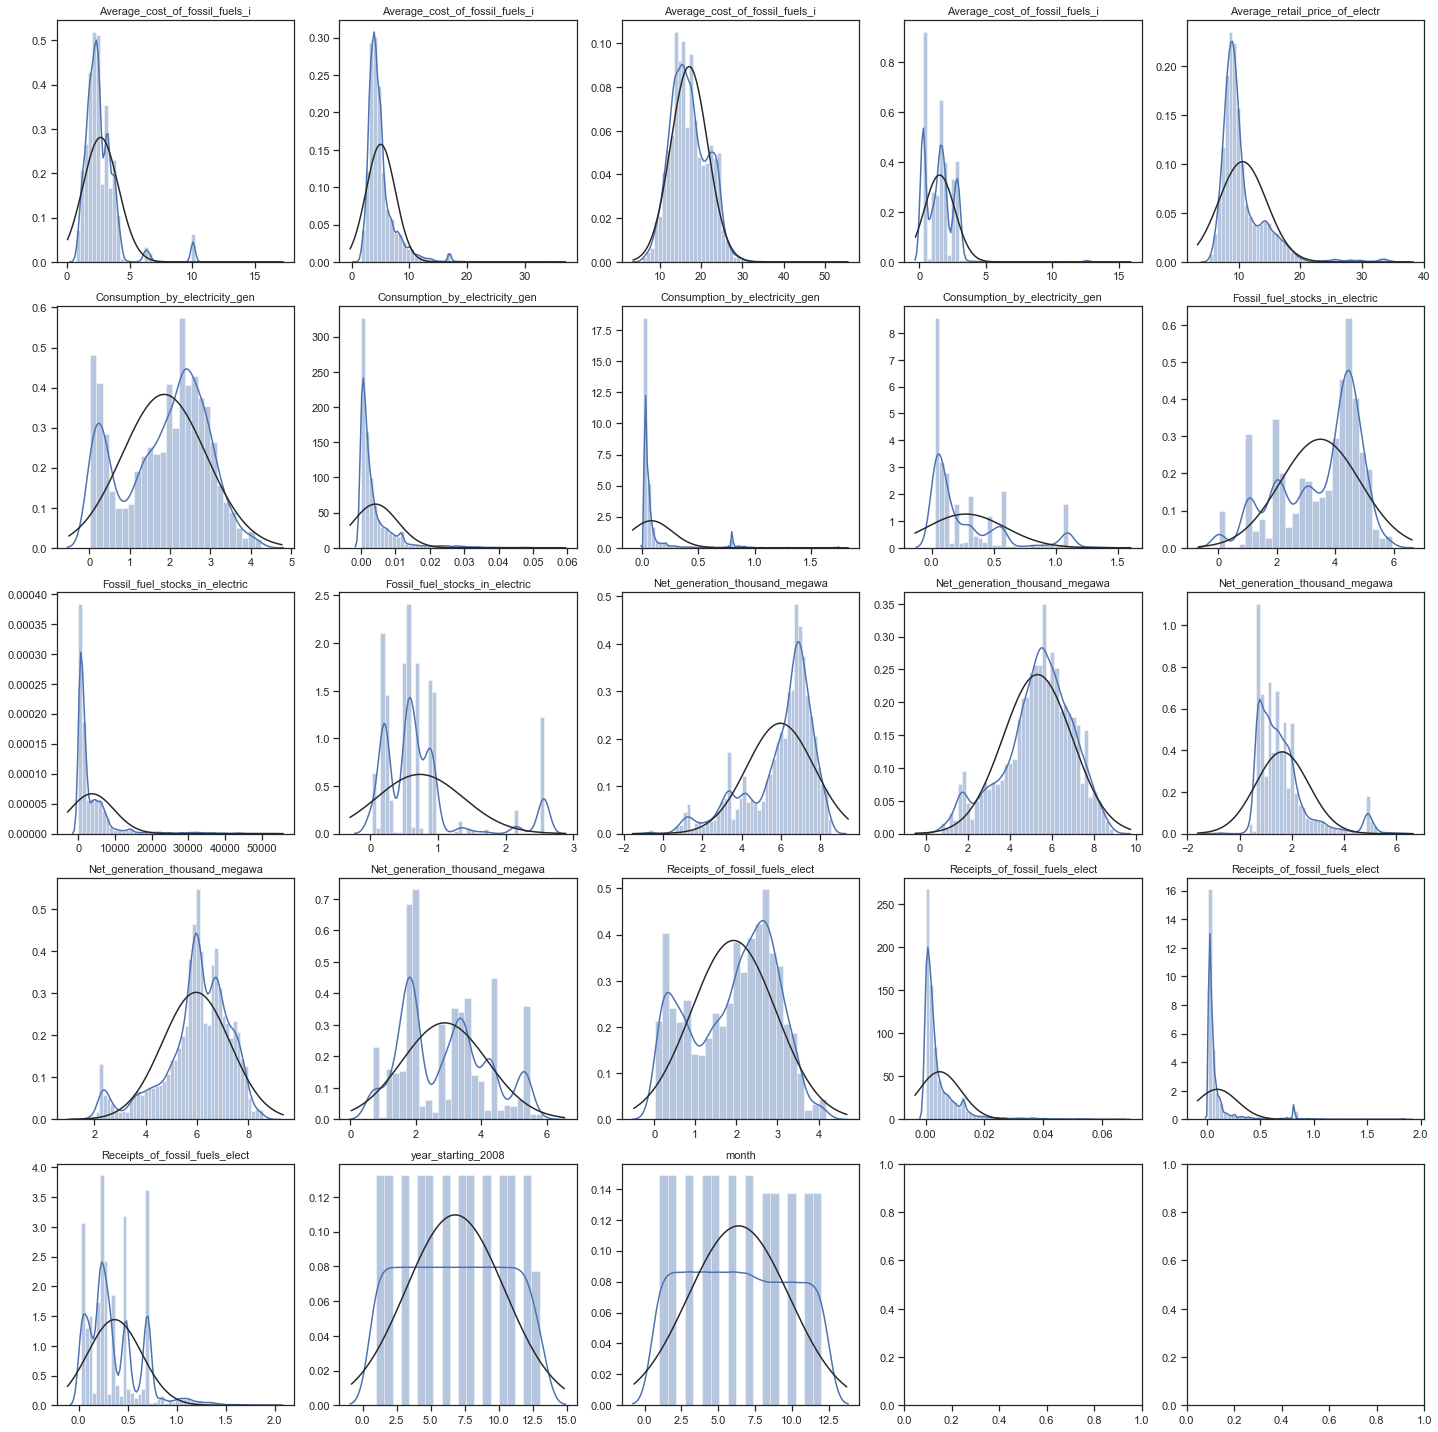

In [18]:
model_df4 = transform_check_distributions(model_df3)
model_df4 = model_df4.reset_index(drop=True)
target_var = 'Average_retail_price_of_electricity_cents_per_kilowatthour__electricity'

# Review Impacts of Key Categorical Variables on Target Variable

 - Electricity prices tend to be quite volatile and cyclical, with annual and hourly seasonality behaviors in between.  Needless to say, there can be quite volatile and will generally show significant outliers from a variety of unique events impacting the market.  For example, when a nuclear plant goes down on the east coast it can cause power prices in the area to rocket up over `$`1,000 per MWh for a brief period of time.
 
 - Petroleum liquids have the largest variation and range in prices per Btu compared to natural gas, petroleum coke, and coal.  Petroleum liquids are also the most expensive per Btu, however, petroleum coke is the most inexpensive, high-energy-value fuel in the market and comes off as a bi-product of the petroleum refining process.
 
 - The total data points on petroleum liquids are lower than other energy types, so reliability could be slightly compromised with a smaller data set and a comparatively smaller grouping in the dataset.

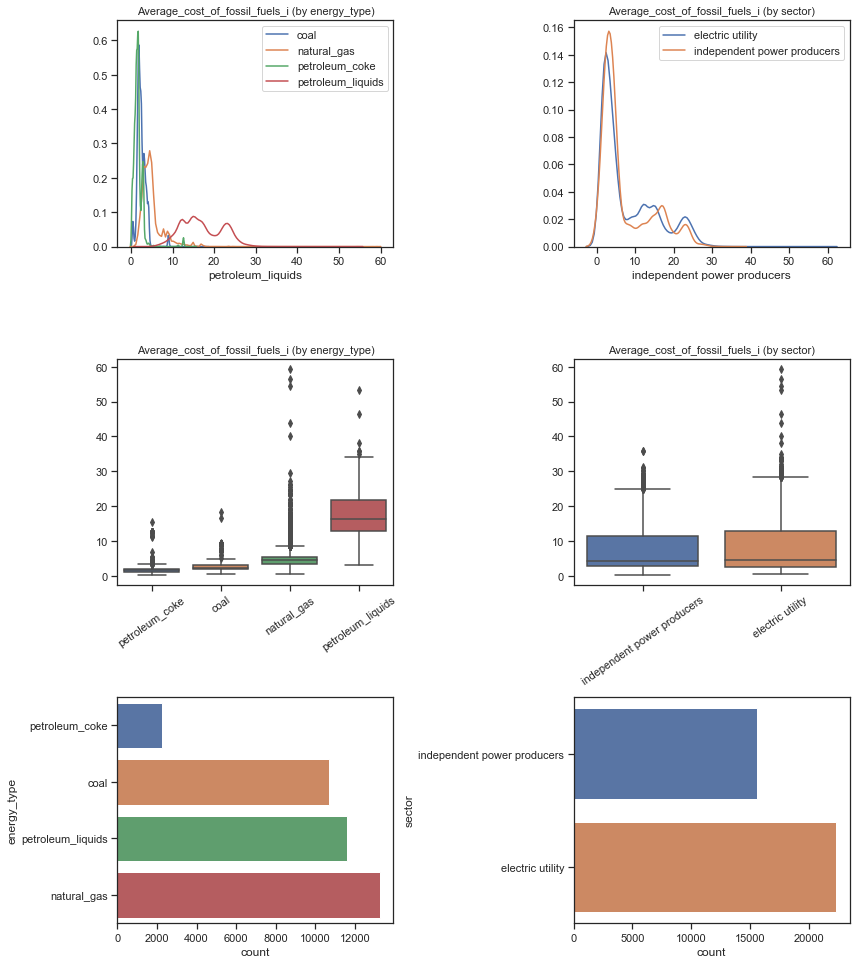

In [19]:
graph_df = df_fill_long.set_index(
    ['variable', 'location', 'energy_type', 'sector', 'year_month']
    ).unstack('variable')
graph_df.columns = graph_df.columns.droplevel(0)

graph_var_list = [
    'Average_cost_of_fossil_fuels_in_electricity_generation_per_Btu_dollars_per_million_Btu'
]

for var in graph_var_list:
    target_var_graph_df = graph_df[var].reset_index().dropna()
    discrete_feature_effects(target_var_graph_df.reset_index(),
                             var, ['energy_type', 'sector'])

# Separate Data Into Training and Test Sets for Supervised Machine Learning Models

In [20]:
# Split data into training and test sets.
test_size = 0.20
random_state = 432
X_train, X_test, y_train, y_test = \
    split_training_test_data(model_df4.copy(deep=True), target_var, test_size, random_state)

The number of observations in training set is 6160
The number of observations in test set is 1541


# Run a Linear Regression on the Model Data

Stats Models Results:


<class 'statsmodels.iolib.summary.Summary'>
"""
                                                       OLS Regression Results                                                      
===================================================================================================================================
Dep. Variable:     Average_retail_price_of_electricity_cents_per_kilowatthour__electricity   R-squared:                       0.558
Model:                                                                                 OLS   Adj. R-squared:                  0.556
Method:                                                                      Least Squares   F-statistic:                     351.9
Date:                                                                     Mon, 09 Nov 2020   Prob (F-statistic):               0.00
Time:                                                                             15:30:43   Log-Likelihood:                -14535.
No. Observations:                                                                     6160   AIC:                         2.912e+04
Df Residuals:                                                                         6137   BIC:                         2.927e+04
Df Model:                                                                               22                                         
Covariance Type:                                                                 nonrobust                                         
=============================================================================================================================================================================
                                                                                                                coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                                      2.654e-06   3.93e-07      6.752      0.000    1.88e-06    3.42e-06
Average_cost_of_fossil_fuels_in_electricity_generation_per_Btu_dollars_per_million_Btu__coal                  0.1155      0.034      3.364      0.001       0.048       0.183
Average_cost_of_fossil_fuels_in_electricity_generation_per_Btu_dollars_per_million_Btu__natural_gas           0.1768      0.016     11.100      0.000       0.146       0.208
Average_cost_of_fossil_fuels_in_electricity_generation_per_Btu_dollars_per_million_Btu__petroleum_liquids     0.0012      0.008      0.151      0.880      -0.015       0.017
Average_cost_of_fossil_fuels_in_electricity_generation_per_Btu_dollars_per_million_Btu__petroleum_coke       -0.2434      0.032     -7.523      0.000      -0.307      -0.180
Consumption_by_electricity_generation_million_MMBtu__coal                                                    -1.3141      0.134     -9.833      0.000      -1.576      -1.052
Consumption_by_electricity_generation_million_MMBtu__natural_gas                                            425.6596     35.830     11.880      0.000     355.420     495.899
Consumption_by_electricity_generation_million_MMBtu__petroleum_liquids                                        2.0345      0.573      3.554      0.000       0.912       3.157
Consumption_by_electricity_generation_million_MMBtu__petroleum_coke                                          -2.4726      0.218    -11.338      0.000      -2.900      -2.045
Fossil_fuel_stocks_in_electricity_generation_million_MMBtu__coal                                             -0.9262      0.054    -17.070      0.000      -1.033      -0.820
Fossil_fuel_stocks_in_electricity_generation_MMBtu__petroleum_liquids                                     -1.694e-06   7.84e-06     -0.216      0.829   -1.71e-05    1.37e-05
Fossil_fuel_stocks_in_electricity_generation_million_MMBtu__petr

The p-values are less than zero for all coefficients, so they are statistically significant.


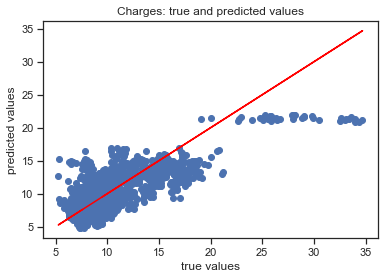

Mean absolute error of the prediction is: 1.9
Mean squared error of the prediction is: 7.0
Root mean squared error of the prediction is: 2.6
Mean absolute percentage error of the prediction is: 18.2

Coefficients: 
 [ 1.15547373e-01  1.76815065e-01  1.22790864e-03 -2.43443167e-01
 -1.31408713e+00  4.25659562e+02  2.03446639e+00 -2.47260670e+00
 -9.26245826e-01 -1.69389703e-06  3.84222108e-01  8.05442952e-01
  1.03262874e+00  1.76868209e-01 -1.13847279e+00  9.01165265e-01
 -8.45427141e-02 -3.55878062e+02  3.64379054e-01 -3.18793059e+00
 -3.12401893e-04 -3.12401965e-04  1.24072275e-02  8.65840814e-03]

Intercept: 
 10.55566095136773
The error term should be zero on average.
Mean of the errors in the model is: -0.000


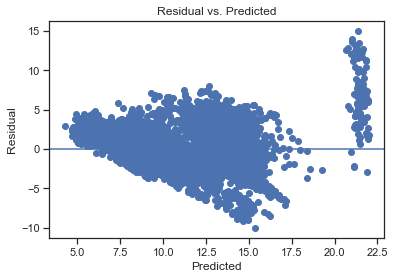

Bartlett test statistic value is 83.0 and p value is 0.000
Levene test statistic value is 86.7 and p value is 0.000
Bartlett and Levene tests both share a null hypothesis that the errors are homoscedastic. If the p-values are less than 0.05, then the results reject the null hypothesis and the errors are heteroscedastic.
Causes of heteroscedasticity include outliers in the data and omitted variables important in explaining the target variance. Include relevant features that target the poorly-estimated areas or transform the dependent variable. Models which suffer from heteroscedasticity still have estimated coefficients which are consistent (still valid).  The reliability of some statistical tests, like the t-test, are affected and may make some estimated coefficients falsely appear to be statistically insignificant.


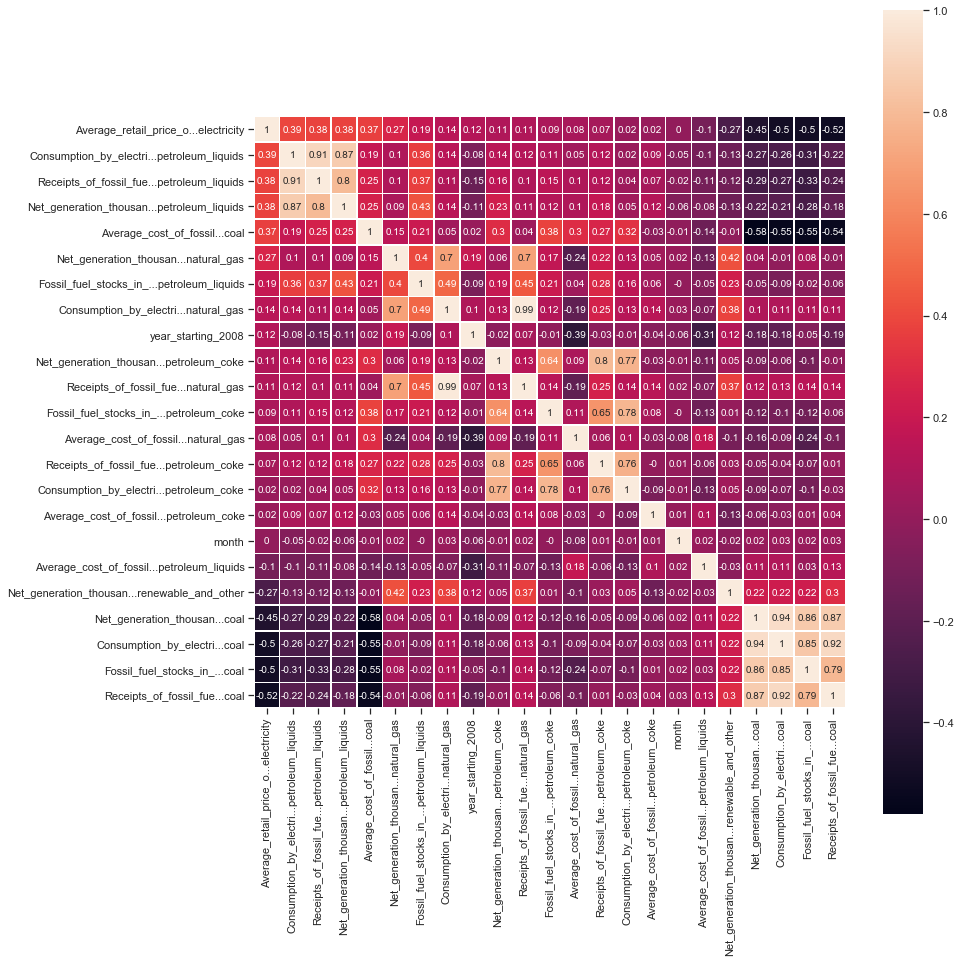

Individual features are only weakly correlated with one another, therefore we have low multicolinearity.


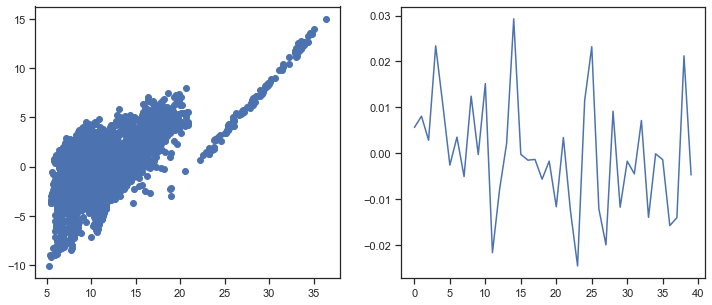

The error terms should be uncorrelated with one another (low R-values).


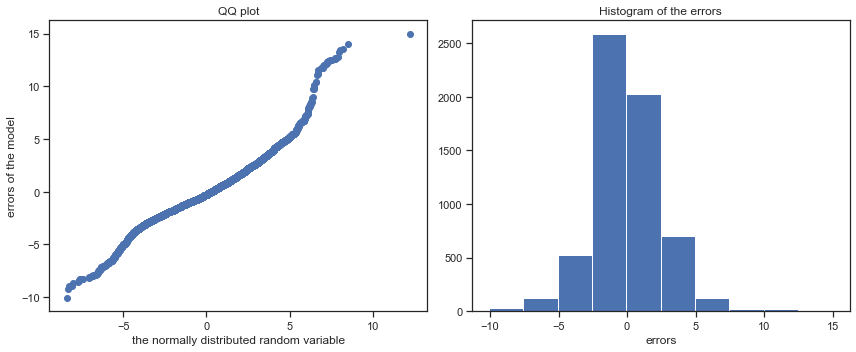

Jarque-Bera test statistics is 3,006.8 and p value is 0.000
Normality test statistics is 792.3 and p value is 0.000
The errors appear to be normally distributed from a visual inspection.
The p-values of both tests (<0.05) indicate that our errors are not normally distributed.


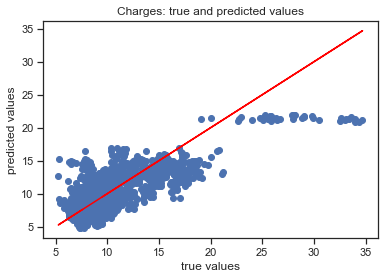

Mean absolute error of the prediction is: 1.9
Mean squared error of the prediction is: 7.0
Root mean squared error of the prediction is: 2.6
Mean absolute percentage error of the prediction is: 18.2
SK Learn Linear Regression - Adjusted R-squared value: 0.57 with RMSE of 2.6.


In [21]:
# Generate linear regression using OLS and check for Markov assumptions.
lr_rval, lr_rmse = generate_linear_regression(model_df4, target_var, X_train, y_train, X_test, y_test)
print("SK Learn Linear Regression - Adjusted R-squared value: {:,.2f} with RMSE of {:,.1f}.".format(
    lr_rval, lr_rmse))

# Run a Random Forest Regression, Plain Vanilla

count   1,541.000
mean       10.693
std         3.970
min         5.368
25%         8.435
50%         9.404
75%        11.412
max        33.776
dtype: float64

Adjusted R-value: 0.98 

Cross Validation Scores:


array([0.98, 0.97, 0.94, 0.98, 0.99, 0.98, 0.98, 0.97, 0.98, 0.98])

Mean absolute error of the prediction is: $0.32
Mean squared error of the prediction is: $0.32
Root mean squared error of the prediction is: $0.56
Mean absolute percentage error of the prediction is: 39.3%


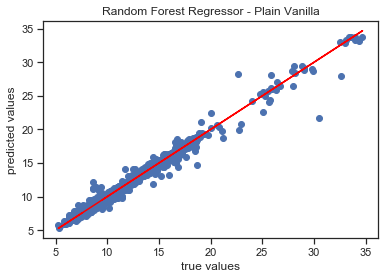

In [22]:
rf_regr = RandomForestRegressor(max_depth=None, random_state=432)
rf_regr.fit(X_train, y_train)
rfr_pred = pd.Series(rf_regr.predict(X_test))
display(rfr_pred.describe())
rf_regr_score = rf_regr.score(X_test, y_test)
print("Adjusted R-value: {:,.2f}".format(rf_regr_score), "\n\nCross Validation Scores:")
display(cross_val_score(rf_regr, pd.concat([X_train, X_test]), pd.concat([y_train, y_test]), cv=10).round(2))

print("Mean absolute error of the prediction is: ${:,.2f}".format(mean_absolute_error(y_test, rfr_pred)))
print("Mean squared error of the prediction is: ${:,.2f}".format(mse(y_test, rfr_pred)))
print("Root mean squared error of the prediction is: ${:,.2f}".format(rmse(y_test, rfr_pred)))
print("Mean absolute percentage error of the prediction is: {:,.1f}%".format(np.mean(np.abs((y_test - rfr_pred) / y_test)) * 100))

plt.scatter(y_test, rfr_pred)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Random Forest Regressor - Plain Vanilla")
plt.show()

# Random Forest Regression with Randomized Search Cross Validation for Hyperparameter Tuning

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   45.0s finished


RF Random best parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': False}


count   1,541.000
mean       10.701
std         3.970
min         5.507
25%         8.472
50%         9.388
75%        11.451
max        33.894
dtype: float64

Adjusted R-value: 0.99 

Cross Validation Scores:
Mean absolute error of the prediction is: $0.29
Mean squared error of the prediction is: $0.22
Root mean squared error of the prediction is: $0.47
Mean absolute percentage error of the prediction is: 39.4%


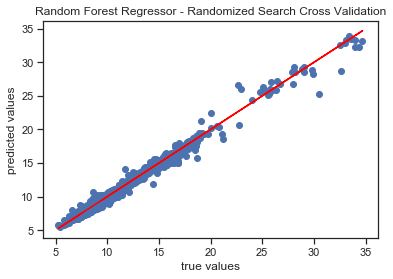

In [23]:
rf_regr_random = RandomForestRegressor(max_depth=None, random_state=432)

random_grid = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30],
    'max_features': [2, 3, 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [50, 75, 100]
}

rf_random = RandomizedSearchCV(estimator=rf_regr_random, param_distributions=random_grid, 
                               n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
                               # scoring="neg_mean_squared_error")
# Fit the random search model
rf_random.fit(X_train, y_train)
print("RF Random best parameters:", rf_random.best_params_)
rf_best_random = rf_random.best_estimator_
rfr_random_pred = pd.Series(rf_best_random.predict(X_test))
display(rfr_random_pred.describe())
print("Adjusted R-value: {:,.2f}".format(rf_best_random.score(X_test, y_test)), "\n\nCross Validation Scores:")
# display(cross_val_score(rf_random, pd.concat([X_train, X_test]), pd.concat([y_train, y_test]), cv=10).round(2))

print("Mean absolute error of the prediction is: ${:,.2f}".format(mean_absolute_error(y_test, rfr_random_pred)))
print("Mean squared error of the prediction is: ${:,.2f}".format(mse(y_test, rfr_random_pred)))
print("Root mean squared error of the prediction is: ${:,.2f}".format(rmse(y_test, rfr_random_pred)))
print("Mean absolute percentage error of the prediction is: {:,.1f}%".format(np.mean(np.abs((y_test - rfr_random_pred) / y_test)) * 100))

plt.scatter(y_test, rfr_random_pred)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Random Forest Regressor - Randomized Search Cross Validation")
plt.show()

# Random Forest Regression with Grid Search Cross Validation for Hyperparameter Tuning

Fitting 3 folds for each of 486 candidates, totalling 1458 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1458 out of 1458 | elapsed:  3.4min finished


{'bootstrap': False, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


count   1,541.000
mean       10.702
std         3.975
min         5.559
25%         8.465
50%         9.391
75%        11.401
max        33.754
dtype: float64

Adjusted R-value: 0.99 

Cross Validation Scores:
Mean absolute error of the prediction is: $0.29
Mean squared error of the prediction is: $0.20
Root mean squared error of the prediction is: $0.45
Mean absolute percentage error of the prediction is: 39.5%


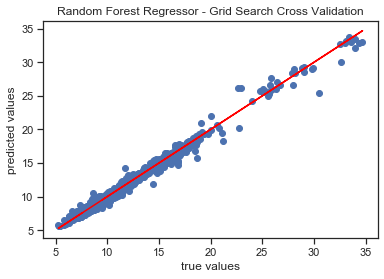

In [24]:
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30],
    'max_features': [2, 3, 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [50, 75, 100]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
rf_grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                          cv=3, n_jobs=-1, verbose = 2)
rf_grid_search.fit(X_train, y_train)
print(rf_grid_search.best_params_)
rf_best_grid = rf_grid_search.best_estimator_
rfr_grid_pred = pd.Series(rf_best_grid.predict(X_test))
display(rfr_grid_pred.describe())
print("Adjusted R-value: {:,.2f}".format(rf_best_grid.score(X_test, y_test)), "\n\nCross Validation Scores:")
# display(cross_val_score(rf_random, pd.concat([X_train, X_test]), pd.concat([y_train, y_test]), cv=10).round(2))

print("Mean absolute error of the prediction is: ${:,.2f}".format(mean_absolute_error(y_test, rfr_grid_pred)))
print("Mean squared error of the prediction is: ${:,.2f}".format(mse(y_test, rfr_grid_pred)))
print("Root mean squared error of the prediction is: ${:,.2f}".format(rmse(y_test, rfr_grid_pred)))
print("Mean absolute percentage error of the prediction is: {:,.1f}%".format(np.mean(np.abs((y_test - rfr_grid_pred) / y_test)) * 100))

plt.scatter(y_test, rfr_grid_pred)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Random Forest Regressor - Grid Search Cross Validation")
plt.show()

# Support Vector Machine (SVM), Plain Vanilla

count   1,541.000
mean       10.466
std         2.056
min         5.664
25%         9.091
50%        10.480
75%        11.416
max        30.823
dtype: float64

Adjusted R-value: 0.30
Mean absolute error of the prediction is: 1.8
Mean squared error of the prediction is: 11.4
Root mean squared error of the prediction is: 3.4
Mean absolute percentage error of the prediction is: 32.0


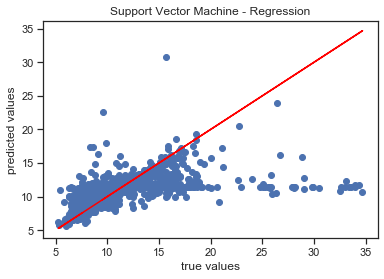

In [25]:
svr = SVR(kernel='rbf', C=1e5, gamma=0.01)
svr.fit(X_train, y_train)
svr_pred = pd.Series(svr.predict(X_test))
display(svr_pred.describe())
print("Adjusted R-value: {:,.2f}".format(svr.score(X_test, y_test)))

print("Mean absolute error of the prediction is: {:,.1f}".format(mean_absolute_error(y_test, svr_pred)))
print("Mean squared error of the prediction is: {:,.1f}".format(mse(y_test, svr_pred)))
print("Root mean squared error of the prediction is: {:,.1f}".format(rmse(y_test, svr_pred)))
print("Mean absolute percentage error of the prediction is: {:,.1f}".format(np.mean(np.abs((y_test - svr_pred) / y_test)) * 100))

plt.scatter(y_test, svr_pred)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Support Vector Machine - Regression")
plt.show()

# Gradient Boosting Regression, Plain Vanilla Hyperparameters

count   1,541.000
mean       10.684
std         3.817
min         6.075
25%         8.588
50%         9.440
75%        11.354
max        33.635
dtype: float64

0.95
Mean absolute error of the prediction is: 0.7
Mean squared error of the prediction is: 0.9
Root mean squared error of the prediction is: 0.9
Mean absolute percentage error of the prediction is: 38.4


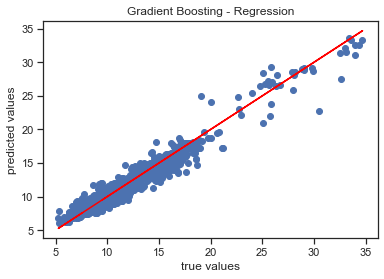

In [26]:
reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train, y_train)
gb_pred = pd.Series(reg.predict(X_test))  # [1:2]
display(gb_pred.describe())
print("{:,.2f}".format(reg.score(X_test, y_test)))

print("Mean absolute error of the prediction is: {:,.1f}".format(mean_absolute_error(y_test, gb_pred)))
print("Mean squared error of the prediction is: {:,.1f}".format(mse(y_test, gb_pred)))
print("Root mean squared error of the prediction is: {:,.1f}".format(rmse(y_test, gb_pred)))
print("Mean absolute percentage error of the prediction is: {:,.1f}".format(np.mean(np.abs((y_test - gb_pred) / y_test)) * 100))

plt.scatter(y_test, gb_pred)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Gradient Boosting - Regression")
plt.show()

# Linear Regressions: Ridge Regression, Lasso Regression, and Elastic Regression

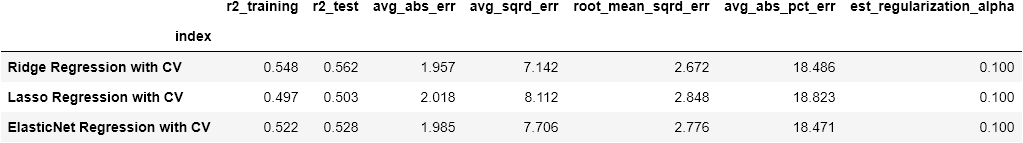

In [32]:
data_dict = {
    'index': [], 
    'r2_training': [], 
    'r2_test': [], 
    'avg_abs_err': [], 
    'avg_sqrd_err': [], 
    'root_mean_sqrd_err': [], 
    'avg_abs_pct_err': [], 
    'est_regularization_alpha': [], 
    'intercept': [], 
    'coef_vectors': [], 
    'l1_l2_ratio': [] 
}

# Ridge Regression with Cross Validation.
ridge_regr_cv = RidgeCV(
    alphas=(0.10, 0.25, 0.50, 0.75, 1.00, 1.50, 2.00, 3.00, 5.00, 10.00), 
    fit_intercept=True, 
    normalize=False, 
    scoring=None, 
    cv=5, 
    gcv_mode=None, 
    store_cv_values=False # ridge_regr_cv.coef_
)
ridge_regr_cv.fit(X_train, y_train)
y_preds_train_ridgecv = ridge_regr_cv.predict(X_train)
y_preds_test_ridgecv = ridge_regr_cv.predict(X_test)
data_dict['index'].append('Ridge Regression with CV')
data_dict['r2_training'].append(ridge_regr_cv.score(X_train, y_train))
data_dict['r2_test'].append(ridge_regr_cv.score(X_test, y_test))
data_dict['avg_abs_err'].append(mean_absolute_error(y_test, y_preds_test_ridgecv))
data_dict['avg_sqrd_err'].append(mse(y_test, y_preds_test_ridgecv))
data_dict['root_mean_sqrd_err'].append(rmse(y_test, y_preds_test_ridgecv))
data_dict['avg_abs_pct_err'].append( np.mean( np.abs( (y_test - y_preds_test_ridgecv) / y_test ) ) * 100 )
data_dict['est_regularization_alpha'].append(ridge_regr_cv.alpha_)
data_dict['intercept'].append(ridge_regr_cv.intercept_)
data_dict['coef_vectors'].append(ridge_regr_cv.coef_)
data_dict['l1_l2_ratio'].append(np.nan)


# Lasso Regression with Cross Validation.
lasso_regr_cv = LassoCV(
    alphas=(0.10, 0.25, 0.50, 0.75, 1.00, 1.50, 2.00, 3.00, 5.00, 10.00), 
    fit_intercept=True, 
    normalize=False,  
    cv=5, 
    n_alphas=None
)
lasso_regr_cv.fit(X_train, y_train)
y_preds_train_lassocv = lasso_regr_cv.predict(X_train)
y_preds_test_lassocv = lasso_regr_cv.predict(X_test)
data_dict['index'].append('Lasso Regression with CV')
data_dict['r2_training'].append(lasso_regr_cv.score(X_train, y_train))
data_dict['r2_test'].append(lasso_regr_cv.score(X_test, y_test))
data_dict['avg_abs_err'].append(mean_absolute_error(y_test, y_preds_test_lassocv))
data_dict['avg_sqrd_err'].append(mse(y_test, y_preds_test_lassocv))
data_dict['root_mean_sqrd_err'].append(rmse(y_test, y_preds_test_lassocv))
data_dict['avg_abs_pct_err'].append( np.mean( np.abs( (y_test - y_preds_test_lassocv) / y_test ) ) * 100 )
data_dict['est_regularization_alpha'].append(lasso_regr_cv.alpha_)
data_dict['intercept'].append(lasso_regr_cv.intercept_)
data_dict['coef_vectors'].append(lasso_regr_cv.coef_)
data_dict['l1_l2_ratio'].append(np.nan)


# ElasticNet Regression with Cross Validation.
elastic_regr_cv = ElasticNetCV(
    l1_ratio=[0.10, 0.50, 0.70, 0.90, 0.95, 0.99, 1.00], 
    alphas=(0.10, 0.25, 0.50, 0.75, 1.00, 1.50, 2.00, 3.00, 5.00, 10.00), 
    fit_intercept=True, 
    normalize=False,  
    cv=5, 
    n_alphas=None
)
elastic_regr_cv.fit(X_train, y_train)
y_preds_train_elasticcv = elastic_regr_cv.predict(X_train)
y_preds_test_elasticcv = elastic_regr_cv.predict(X_test)
data_dict['index'].append('ElasticNet Regression with CV')
data_dict['r2_training'].append(elastic_regr_cv.score(X_train, y_train))
data_dict['r2_test'].append(elastic_regr_cv.score(X_test, y_test))
data_dict['avg_abs_err'].append(mean_absolute_error(y_test, y_preds_test_elasticcv))
data_dict['avg_sqrd_err'].append(mse(y_test, y_preds_test_elasticcv))
data_dict['root_mean_sqrd_err'].append(rmse(y_test, y_preds_test_elasticcv))
data_dict['avg_abs_pct_err'].append( np.mean( np.abs( (y_test - y_preds_test_elasticcv) / y_test ) ) * 100 )
data_dict['est_regularization_alpha'].append(elastic_regr_cv.alpha_)
data_dict['intercept'].append(elastic_regr_cv.intercept_)
data_dict['coef_vectors'].append(elastic_regr_cv.coef_)
data_dict['l1_l2_ratio'].append(elastic_regr_cv.l1_ratio_)

data_dict.pop('coef_vectors')
df = pd.DataFrame.from_dict(data_dict).set_index('index')
df_img_out(df.head(5).iloc[:, :7], 'ridge_lasso_elastic')

# Analyze and Compare Model Approaches and Final Results

__The Random Forest Regression with a Grid Search Cross Validation was the best model based upon the highest adjusted R-value of 0.987, indicating a goodness of fit to the test data and the lowest root mean squared error (RMSE) of \$0.45 indicating superior results with the test data or predictive modeling power.__  

 - A Linear Regression resulted in an RMSE of the prediction of `$2.64` and adjusted R-squared value of `0.57`.  Linear regression kernel variations of Ridge Regression, Lasso Regression, and ElasticNet Regression came to similar figures but were slightly less optimal.

 - A Random Forest Regression, Plain Vanilla resulted in an RMSE of `$0.56` and an adjusted R-squared value of `0.981`.  When Random Search or Grid Search Cross Validation were applied to hyperparameter tuning, the random forest regression improved to an RMSE of `$0.45 - $0.46` and an adjusted R-squared value of `0.987`.  

 - A Support Vector Machine (SVM) Regression, plain vanilla, resulted in an RMSE of `$3.38` and an adjusted R-squared value of `0.30`.  These results were not comparable to the higher performances of other model approaches.  

 - A Gradient Boosting Regression resulted in an RMSE of `$0.94` and an adjusted R-squared value of `0.95`.  

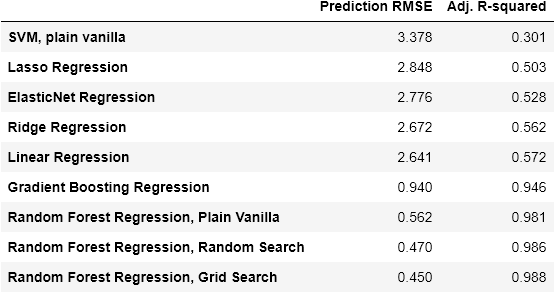

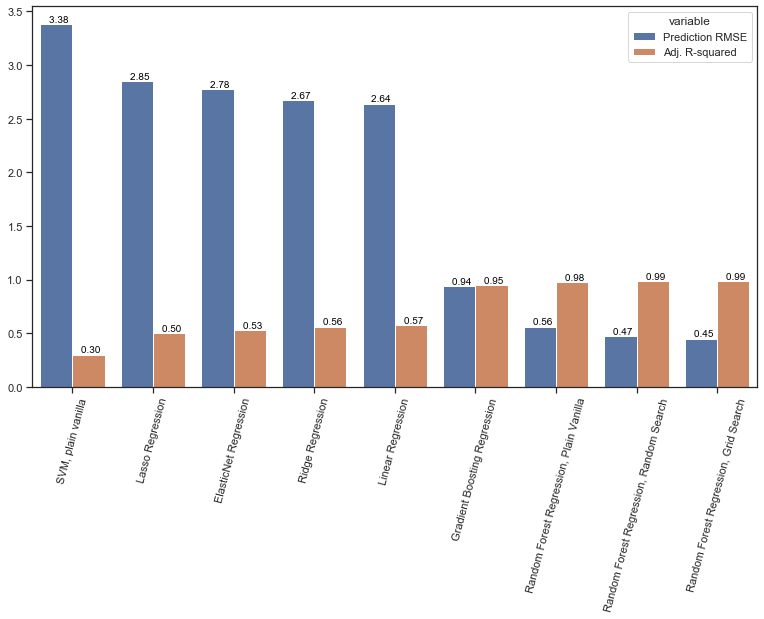

In [33]:
model_results_df = pd.DataFrame.from_dict( {
    'Linear Regression': {
        'Prediction RMSE': lr_rmse, 
         'Adj. R-squared': lr_rval
    },
    'Ridge Regression': {
        'Prediction RMSE': rmse(y_test, y_preds_test_ridgecv),
         'Adj. R-squared': ridge_regr_cv.score(X_test, y_test)
    },
    'Lasso Regression': {
        'Prediction RMSE': rmse(y_test, y_preds_test_lassocv), 
         'Adj. R-squared': lasso_regr_cv.score(X_test, y_test)
    },
    'ElasticNet Regression': {
        'Prediction RMSE': rmse(y_test, y_preds_test_elasticcv), 
         'Adj. R-squared': elastic_regr_cv.score(X_test, y_test)
    },
    'Random Forest Regression, Plain Vanilla': {
        'Prediction RMSE': rmse(y_test, rfr_pred),
         'Adj. R-squared': rf_regr_score # rf_regr.score(X_test, y_test)
    },
    'Random Forest Regression, Random Search': {
        'Prediction RMSE': rmse(y_test, rfr_random_pred),
         'Adj. R-squared': rf_best_random.score(X_test, y_test)
    },
    'Random Forest Regression, Grid Search': {
        'Prediction RMSE': rmse(y_test, rfr_grid_pred),
         'Adj. R-squared': rf_best_grid.score(X_test, y_test)
    },
    'SVM, plain vanilla': {
        'Prediction RMSE': rmse(y_test, svr_pred),
         'Adj. R-squared': svr.score(X_test, y_test)
    },
    'Gradient Boosting Regression': {
        'Prediction RMSE': rmse(y_test, gb_pred),
         'Adj. R-squared': reg.score(X_test, y_test)},
} ).transpose().sort_values(by=['Adj. R-squared'])
df_img_out(model_results_df.head(20).iloc[:, :7], 'model_results_df')
sns_df = model_results_df.reset_index().melt(id_vars=['index'])
plt.figure(figsize=(13,7))
ax = sns.barplot(x='index', y='value', hue='variable', data=sns_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=75)
for p in ax.patches:
        ax.annotate('{:<8,.2f}'.format(p.get_height()), ( p.get_x() + 0.3, p.get_height() ),
                    ha='center', va='bottom', color='black', fontsize='medium')
ax.set_ylabel('')
ax.set_xlabel('')
plt.show()

# Appendix: Additional Data Wrangling Code to Create 'eia_data.csv'.

In [29]:
"""
    Take a folder path and generate a 2D dictionary of file names and paths of all .csv files 
    within the selected folder.  The keys are the file names with '.csv' extensions in the folder.
    Each item value is a 2-key dictionary holding 'path' and 'name.'  This csv dictionary is later
    used as an input parameter for csv_list_to_dataframes().
        Function call example:
        location = "C:\\dev\\Thinkful\\25. Supervised Learning Capstone Project\\EIA Data Sources\\"
        csv_data_set1 = make_csv_dict(location)
"""
def make_csv_dict(location):
    file_list = []
    # r=>root, d=>directories, f=>files
    for r, d, f in os.walk(location):
       for item in f:
          file_list.append(item) if '.csv' in item else next
    csv_data_set = {}
    for item in file_list:
        csv_data_set[item.replace('.csv', '')] = {'path': location, 'name': item}
    return csv_data_set




"""
    Read csv file to determine row number of data headers.
        Helper function for csv_list_to_df_dict().
        csv_header_row = get_header_row(full_csv_path)
"""
def get_header_row(full_csv_path):
    file_obj = open(full_csv_path)
    csv_reader_obj = csv.reader(file_obj)
    header_row = 0
    for row in csv_reader_obj:
        if len(row) > 1:
            break
        header_row += 1
    return header_row




"""
    Take a structured dictionary of CSV file locations or web addresses and download
    the data into a dictionary of dataframes.  Also checks to see if all the columns
    are matching on the tables or not.  Function call example:
        columns_df = csv_list_to_dataframes(csv_data_set, df_dict)
"""
def csv_list_to_df_dict(csv_data_set, df_dict, na_values):
    # Setup data buckets for loop through csv files.
    summary_df = pd.DataFrame()
    dfs_summary_dict = {}
    summary_df_col_index = []
    col_rename_dict = {}
    column_max_count, max_key = 0, ''
    
    # Loop keys/csv filenames to fill df dictionary and matching column check table.
    for table_name in csv_data_set.keys():
        
        # Download the csv file into a DataFrame and add it to the df_dict.
        full_csv_path = csv_data_set[table_name]['path'] \
                      + csv_data_set[table_name]['name']
        csv_header_row = get_header_row(full_csv_path)
        data = pd.read_csv(full_csv_path, header = csv_header_row, na_values=na_values)#.fillna(0)
        df_dict[table_name] = data.copy()
        
        # Collect summary information on the DataFrames.
        col_data = list(df_dict[table_name].columns)
        dfs_summary_dict.update({ table_name: col_data })
        if len(df_dict[table_name].columns) > column_max_count:
            column_max_count = len(df_dict[table_name].columns)
            max_key = table_name
    
    # Select one of the largest DataFrames to set the column order.
    column_index_key = df_dict[max_key].columns
    
    # Modify list of column values in dfs_summary_dict > summary_df.
    matches, insertions = 0, 0
    for report, col_data in dfs_summary_dict.items(): 
        col_idx = 0
        for key_idx in range(0, len(column_index_key)):
            no_match = column_index_key[key_idx] != col_data[col_idx]
            if no_match:
                col_data.insert(col_idx, np.nan)
                insertions += 1
                col_idx += 1
            else:
                matches += 1
                col_idx += 1
    equalized_columns = { key: pd.Series(value) for key, value in dfs_summary_dict.items() }
    equalized_columns_df = pd.DataFrame.from_dict(equalized_columns)
    summary_df_col_index += list(equalized_columns_df.columns)
    for i in range(len(summary_df_col_index)):
        col_rename_dict.update({i: summary_df_col_index[i]})
    concat_list = [summary_df, equalized_columns_df]
    summary_df = pd.concat(concat_list, copy=False, axis='columns')[equalized_columns_df.columns]
    summary_df.rename(columns=col_rename_dict, inplace=True)
    equal_columns = summary_df.apply(lambda row: row[0] == row.all(), axis=1)
    summary_df.insert(loc=0, column='_equal_table_columns', value=equal_columns)
    
    # Copy into a column-only dataframe, match_columns_df, excluding dimension rows.
    match_columns_df = summary_df.reset_index(drop=True).copy(deep=True)
    val_cnts = match_columns_df['_equal_table_columns'].value_counts()    
    summary_df.index.name = 'col_pos'
    summary_df = summary_df.transpose()
    summary_df.index.name = 'table_names'
    summary_df.reset_index(inplace=True)
    print("\n{:,} matching columns and {:,} mis-matching columns (element-wise including NaNs) for all csv tables > dataframes.".format(
        val_cnts.at[True] if True in val_cnts.index else 0,      
        val_cnts.at[False] if False in val_cnts.index else 0))
    print("{:,} max columns across all dataframes.".format(column_max_count))
    return summary_df, column_index_key




"""
    Take a dictionary of dataframes and convert them into a single large dataframe.
    Also checks to see if the columns names and total row numbers are matching on the tables or not.
    Function call example:
        folder_df1 = df_dict_to_single_df(df_dict1)
"""
def df_dict_to_folder_df(df_dict, column_index_key):
    # Concatenate vertically along 0/columns and multi-index on csv names.
    new_row_label = 'csv_table_names'
    df_list = []
    table_row_counts = []
    for key, df in df_dict.items():
        table_row_counts.append(df.shape[0])
        csv_name_col = df.apply(lambda row: key, axis=1)
        df.insert(loc=0, column=new_row_label, value=csv_name_col)
        df_list.append(df) 
    column_index_key = column_index_key.insert(0, new_row_label)
    folder_df = pd.concat(df_list)
    folder_df.reset_index(drop=True, inplace=True)
    
    # Check if concatenation may have date-based alignment errors.
    folder_df_concat_good = folder_df.shape[0] == sum(table_row_counts)
    if not folder_df_concat_good:
        print("ERROR: Concatenation of DataFrames did not result in the same number of rows.".format(bad_stat))
        print("{:,} total rows in the dictionary of DataFrames.".format(sum(table_row_counts)))
        print("{:,} rows in the vertically concatenated DataFrame result.".format(folder_df.shape[0]))  
    return folder_df, column_index_key




"""
    Drop zero-sum numeric rows from dataframe folder_df.  If non_numeric_cols are not provided
    in a manual list, then Numeric columns are selected by their data type being either 
    int64 or float64.  Function call example:
        non_numeric_cols = ['description', 'units', 'source key']
        drop_zero_sum_numeric_rows(folder_df, non_numeric_cols)
"""
def drop_zero_sum_numeric_rows(folder_df, non_numeric_cols=None):
    if non_numeric_cols == None:
        non_numeric_cols = []
        dtype_dict = dict(folder_df.dtypes)
        for col in dtype_dict:
            if dtype_dict[col] != 'float64' and dtype_dict[col] != 'int64':
                non_numeric_cols.append(col)    
    numeric_df = folder_df.drop(columns=non_numeric_cols)
    zero_rows_df = pd.DataFrame(numeric_df.apply(lambda row: True if np.sum(row) == 0 else False, axis=1),
                                columns=['zero_sum_rows'],
                                index=numeric_df.index)
    zero_rows_only_df = zero_rows_df[zero_rows_df['zero_sum_rows'] == True]
    
    # Drop rows with zero sum numeric amounts.
    folder_df.drop(index=zero_rows_only_df.index, inplace=True)
    
    # Count rows and check for potential errors.
    all_row_ct = zero_rows_df.shape[0]
    zero_sum_row_ct = zero_rows_only_df.shape[0]
    remaining_row_ct = folder_df.shape[0]
    if all_row_ct != (zero_sum_row_ct + remaining_row_ct):
        print("Total rows {} less {} non-numeric rows equals {}, but folder_df now has {}".format(
              all_row_ct, zero_sum_row_ct, all_row_ct - zero_sum_row_ct, remaining_row_ct))
    folder_df.reset_index(drop=True, inplace=True)
    folder_df.index.rename('index', inplace=True)
    return folder_df



"""
    Aggregate functions to combine data from multiple CSV files within a specified folder.
"""
def csv_folder_to_df(folder_location, na_values):
    df_dict = {}
    column_index_key = pd.DataFrame()
    csv_data_set = make_csv_dict(folder_location)
    summary_df, column_index_key = csv_list_to_df_dict(csv_data_set, df_dict, na_values)
    folder_df, column_index_key = df_dict_to_folder_df(df_dict, column_index_key)
    folder_df_non_zero = drop_zero_sum_numeric_rows(folder_df)
    return folder_df_non_zero

# folder_location = "C:\\dev\\Thinkful\\25. Supervised Learning Capstone Project\\EIA Data Sources\\"
# eia_raw_data_df = csv_folder_to_df(folder_location, na_values)
# eia_raw_data_df.to_csv('eia_data.csv')
# na_values = ['', '--', 'NM', 'W']